# Whittle likelihood for 1-yr signal WITH GAPS

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import warnings
import multiprocessing
import os, datetime
from tqdm import tqdm
from astropy import units as u

from lisatools.diagnostic import *
from lisatools.sensitivity import SensitivityMatrix, A1TDISens, E1TDISens, LISASens
from lisatools.utils.constants import *
from lisatools.detector import EqualArmlengthOrbits
from lisatools.datacontainer import DataResidualArray 
from lisatools.analysiscontainer import AnalysisContainer

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import *
from few.trajectory.inspiral import EMRIInspiral

from fastlisaresponse import pyResponseTDI, ResponseWrapper

try:
    import cupy as cp
except Exception:
    cp = None

In [2]:
# gpu
use_gpu = False

Define FEW parameters

In [3]:
# metric
metric = "FastKerrEccentricEquatorialFlux"   # Kerr
traj = "KerrEccEqFlux"

In [4]:
# Observation parameters
Tobs = 1  # [years]
dt = 50.0  # [s]
eps = 1e-5  # mode content

emri_waveform_kwargs = dict(T=Tobs, dt=dt, eps=eps)

In [5]:
# Waveform parameters
M = 1e6  # central object mass
mu = 10  # secondary object mass
a = 0.5  # spin (will be ignored in Schwarzschild waveform)
p0 = 8.2  # initial semi-latus rectum
e0 = 0.5  # eccentricity
x0 = 1.0  # cosine of inclination 
dist = 1.0  # distance

qK = np.pi / 6  # polar spin angle (theta)
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 6  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle

Phi_phi0 = np.pi / 3
Phi_theta0 = np.pi / 6
Phi_r0 = np.pi / 3



emri_waveform_args = [
    M,
    mu,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

Define detector response parameters

In [6]:
# TDI

tdi_chan="AE"
tdi_labels=["A", "E"]

#tdi_chan="AET"
#tdi_labels=["A", "E", "T"]

order = 25 # order of the langrangian interpolation (for strain and orbits?)

tdi_gen="1st generation"
#tdi_gen="2nd generation"


response_kwargs = dict(
        Tobs=Tobs,
        dt=dt,
        t0 = 100000.0,  # time at which signal starts (chops off data at start and end of waveform)
        order = order, # order of the langrangian interpolation (for strain and orbits?)
        index_beta = 7,   # Sky location parameters: theta --> qS
        index_lambda = 8, #                          phi --> phiS
        tdi=tdi_gen, 
        tdi_chan=tdi_chan,
        orbits=EqualArmlengthOrbits(),
    )

Generate TD data with detector response --> chans

In [7]:
# Initialise generator
td_gen = GenerateEMRIWaveform(
        metric,
        sum_kwargs=dict(pad_output=True, odd_len=True),
        return_list=False,
        use_gpu=use_gpu,
    )



lisa_response = ResponseWrapper(waveform_gen=td_gen,
                                flip_hx=True,
                                use_gpu=use_gpu,
                                remove_sky_coords=False,
                                is_ecliptic_latitude=False,
                                remove_garbage=False,
                                **response_kwargs)




def fastlisaresponse(*params, emri_waveform_kwargs=None):
    return lisa_response(*params, **(emri_waveform_kwargs or {}))

In [8]:
# Generate a waveform
start = time.time()
chans = fastlisaresponse(
    *emri_waveform_args,
    emri_waveform_kwargs=emri_waveform_kwargs,
)
print(f"Waveform generation took {time.time()-start:.2f} s")

Waveform generation took 11.63 s


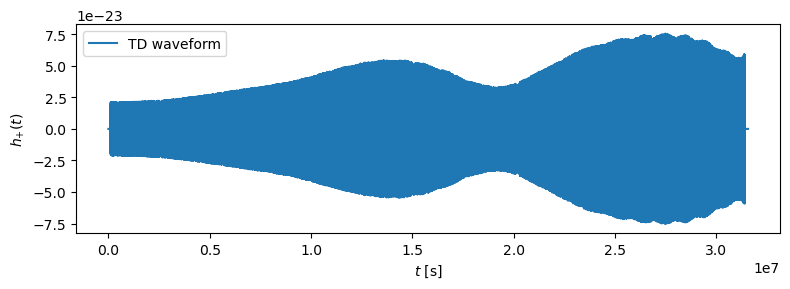

In [9]:
# Visualise the signal
time_array = np.arange(0,len(chans[0]))*dt

plt.figure(figsize=(8,3))
plt.plot(time_array, chans[0], label='TD waveform')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()

## Generate realistic gaps

In [10]:
# conversions
day  = u.day        # Quantity unit (1 day)
hour = u.hour       # Quantity unit (1 hour)
year = 365.25 * u.day   # Julian year as a Quantity

years_to_s = (year).to(u.s).value
days_to_s = (day).to(u.s)
hours_to_s = (hour).to(u.s)

In [11]:
def gen_periodic_gaps(chans, dt, w_total, gap_s, period_s, seed=None):

    rng = np.random.default_rng(seed)

    N_tot = len(chans[0])

    # conversion of gaps and their period to samples
    gap_samples = int(np.round(gap_s / dt))
    period_samples = int(np.round(period_s / dt))

    # random start within one period
    start_idx = int(rng.integers(1, period_samples))
    
    # create mask
    w_local = np.ones(N_tot, dtype=int)
    starts = np.arange(start_idx, N_tot, period_samples)
    for s in starts:
        e = min(s + gap_samples, N_tot)  # within the end of the signal
        w_local[s:e] = 0

    # apply mask
    chans_gap = chans.copy() * w_local
    w_final = w_total.copy() * w_local

    return chans_gap, w_final, starts

In [12]:
def gen_planned_gaps(chans, dt, seed=None):
    N_tot = len(chans[0])
    w_total = np.ones(N_tot, dtype=int)
    
    # Antenna re-pointing    
    gap_ant = 3 * hours_to_s
    period_ant = 14 * days_to_s

    chans_gap_ant, w_final_ant, starts_ant = gen_periodic_gaps(chans, dt, w_total, gap_ant, period_ant, seed=seed)

    
    # Tilt-to-length coupling constant estimation
    gap_ttl = 2 * days_to_s
    period_ttl = 0.25 * years_to_s # 4 times a year

    chans_gap_ttl, w_final_ttl, starts_ttl = gen_periodic_gaps(chans_gap_ant, dt, w_final_ant, gap_ttl, period_ttl, seed=seed)
    

    # point-ahead angle mechanism (PAAM) adjustments
    gap_PAAM = 100
    period_PAAM = (1/3) * days_to_s

    chans_gap_PAAM, w_final_PAAM, starts_PAAM = gen_periodic_gaps(chans_gap_ttl, dt, w_final_ttl, gap_PAAM, period_PAAM, seed=seed)


    return chans_gap_PAAM, w_final_PAAM, starts_ant, starts_ttl, starts_PAAM
    

In [13]:
chans_gap, w_final, starts_ant, starts_ttl, starts_PAAM = gen_planned_gaps(chans, dt, seed=13)

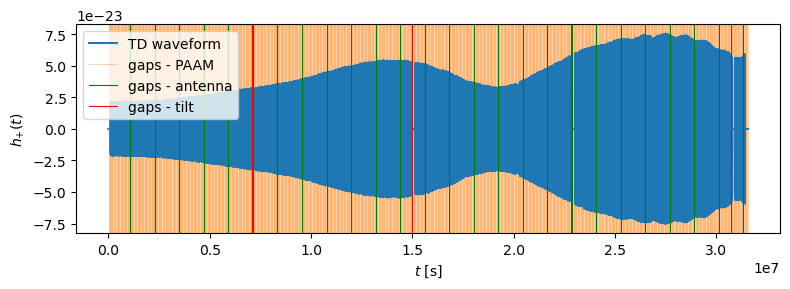

In [14]:
time_array = np.arange(0,len(chans_gap[0]))*dt

plt.figure(figsize=(8,3))

for n,i in enumerate(starts_PAAM):
    plt.axvline(starts_PAAM[n]*dt, color='C1', alpha=0.5, linewidth=0.5)
    
plt.plot(time_array, chans_gap[0], label='TD waveform')

plt.axvline(starts_PAAM[0]*dt, color='C1', label='gaps - PAAM', alpha=0.5, linewidth=0.5)

plt.axvline(starts_ant[0]*dt, color='g', label='gaps - antenna', alpha=1, linewidth=0.8)
for n,i in enumerate(starts_ant):
    plt.axvline(starts_ant[n]*dt, color='g', alpha=1, linewidth=0.8)

plt.axvline(starts_ttl[0]*dt, color='r', label='gaps - tilt', alpha=1, linewidth=0.8)
for n,i in enumerate(starts_ttl):
    plt.axvline(starts_ttl[n]*dt, color='r', alpha=1, linewidth=0.8)
    
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')
#plt.xlim(2.3e7,2.7e7)
plt.legend()
plt.tight_layout()

plt.show()